In [1]:
from utils.binaries import *
from utils.plotting import *

16:56:18 [INFO] utils.binaries -- (+13401ms) -- import numpy as np
16:56:18 [INFO] utils.binaries -- (  +343ms) -- import pandas as pd
16:56:19 [INFO] utils.binaries -- (  +649ms) -- import sklearn.neighbors as sk_neighbors
16:56:19 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as binaries
16:56:20 [INFO] utils.plotting -- (  +415ms) -- import matplotlib.pyplot as plt
16:56:20 [INFO] utils.plotting -- (   +33ms) -- import seaborn as sns
16:56:20 [DBUG] utils.plotting -- (   +13ms) -- font size set to 4
16:56:20 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [2.4, 1.2]
16:56:20 [DBUG] utils.plotting -- (    +0ms) -- plotting style set to `notebook`.
16:56:20 [INFO] utils.plotting -- (    +3ms) -- import plotting.tools as plot


<Axes: >

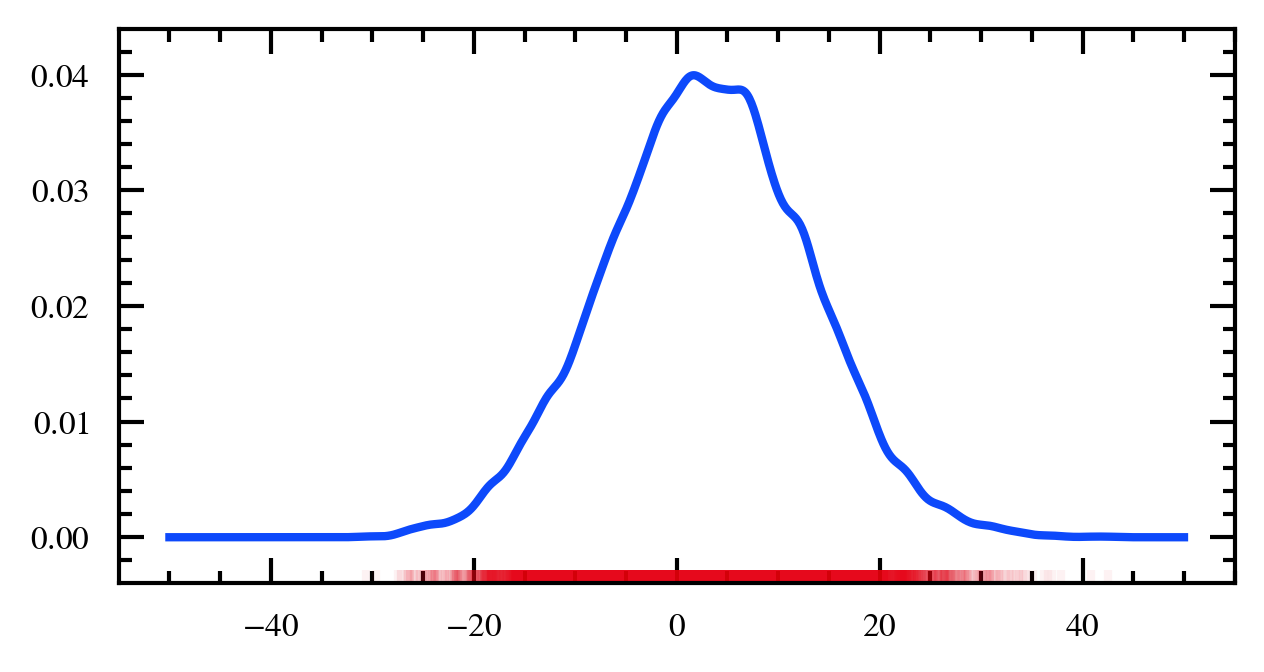

In [3]:
samples = np.random.normal(3, 10, size=10000)
kde = tools.kd1d_estimate(samples)
X = np.linspace(-50, 50, 1000)

plt.plot(X, kde(X))
so.rugplot(samples, lw=0.1, alpha=0.05)